## EECS 491 Assignment 3

### Exercise 1. MRFs and Images Denoising (40 points)

In this problem, you will implement the image de-noising example using a Markov Random Field (MRF).  This material on MRFs is covered in the textbook (Barber) in chapter 4.2.5. The lecture and this problem is based on the presentation in Bishop in chapter 8.3, which is available online.

As discussed in class, energy function for this MRF is

$$ E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_i\sum_{j\in \textrm{ne}(i)} x_i x_j - \eta \sum_i x_i y_i \quad(1)$$

where the binary variables $x_i$ represent the unknown, noise-free image pixels, which are binary, i.e. black or white, and $\textrm{ne}(i)$ indicates the neighbords of node $i$.  The variables $y_i$ represent the observed noisy pixels, i.e. the pixel could randomly change from black ($=-1$) to white ($=+1$) or vice-versa.  

The corresponding joint probability distribution over the variables is

$$ p(\mathbf{x},\mathbf{y}) = \frac{1}{Z} \exp \left[ -E(\mathbf{x},\mathbf{y}) \right] $$

1.1 (5 pts) Derive the equation that specifies the change in the energy equation when one variable changes state.

Representing the variable which changes state as $x_a$, then the change in energy can be defined as

$$\Delta E(\mathbf{x,y}) = E(\mathbf{x^*,y}) - E(\mathbf{x,y}),$$

where $\mathbf{x^*}$ is $\mathbf{x}$ with $-x_a$ instead of $x_a$. In order to find the change in energy, we will need to find the energy with respect to one variable. The total energy equation consists of three terms, so we will break it down into these respective parts. The energy from the first term with respect to one variable is

$$hx_a,$$

and the energy from the third term is

$$-\eta(x_ay_a).$$

The energy from the second term is the effect of $x_a$ on its neighbors, which can be written as

$$-2\beta x_a\sum_{i\in ne(a)}x_i.$$

Writing out the total change, we get

$$\Delta E(\mathbf{x,y}) = h(-x_a - x_a) -2\beta(-\sum_{i\in ne(a)}x_ix_a -\sum_{i\in ne(a)}x_ix_a) -\eta(-x_ay_a - x_ay_a)$$

$$\Delta E(\mathbf{x,y}) = -2hx_a + 4\beta x_a\sum_{i\in ne(a)}x_i + 2\eta x_ay_a$$

$$\Delta E(\mathbf{x,y}) = x_a(-2h + 4\beta\sum_{i\in ne(a)}x_i + 2\eta y_a)\quad(2)$$

1.2 (10 pts) Write a program to iteratively (or in random order) update the state variables to minimize the energy (maximize the probability).  Explain your code.  Show that the update algorithm minimizes the energy $E(\mathbf{x}, \mathbf{y})$.

The algorithm I chose to implement is the Iterated Conditional Modes (ICM) technique described in Bishop. With this technique, we iterate over every pixel in the image and compute what the change in total energy (using Equation 2) would be if the pixel is changed, and if the total energy will decrease then the pixel is flipped. This process continues until one of two conditions: either an entire raster pass occurs where no pixels change value, or a maximum number of iterations is reached.

In [1]:
import numpy as np

def sumNeighbor(x,rInd,cInd):
    # sum(x_i x_j) for j in the neighborhood of i
    # the neighborhood is the adjacent pixels above, below, to the left and to the right of the source pixel
    
    # handle indices getting out of range
    if len(x) == (rInd+1):
        bot = x[0,cInd]
    else:
        bot = x[rInd+1,cInd]
        
    if len(x[0]) == (cInd+1):
        rit = x[rInd,0]
    else:
        rit = x[rInd,cInd+1]
        
    top = x[rInd-1,cInd]
    lft = x[rInd,cInd-1]
    
    #sum neighbors
    total = rit+lft+top+bot
    return total

def deltaEnergy(x,y,h,b,n,rInd,cInd):
    # compute the change in energy using Equation 2
    dE = x[rInd,cInd]*(-2*h + 4*b*sumNeighbor(x,rInd,cInd) + 2*n*y[rInd,cInd])
    return dE

def totalEnergy(x,y,h,b,n):
    # compute the total energy using Equation 1
    total1 = 0
    total2 = 0
    total3 = 0
    
    # calculate terms of energy equation
    for rInd in range(len(x)):
        for cInd in range(len(x[0])):
            total1 = total1 + x[rInd,cInd]
            total2 = total2 + x[rInd,cInd]*sumNeighbor(x,rInd,cInd)
            total3 = total3 + x[rInd,cInd]*y[rInd,cInd]
    
    # sum terms
    E = h*total1 - b*total2 - n*total3
    
    return E

def minEnergy(x,y,h,b,n,maxIter):
    # minimize the energy using the Iterated Conditional Modes (ICM) technique
    iter = 0
    changed = 1
    # run rasters over the image as long as pixels get changed, or a maximum number of iterations is reached
    while (iter < maxIter) and (changed > 0):
        changed = 0
        # iterate through the pixels
        for rInd in range(len(x)):
            for cInd in range(len(x[0])):
                # calculate the change in energy based on the current pixel
                dE = deltaEnergy(x,y,h,b,n,rInd,cInd)
                # if the energy change will reduce the energy,
                if dE < 0:
                    x[rInd][cInd] = -x[rInd][cInd] # flip the pixel value
                    changed = 1
        
        iter = iter + 1
    #print("Finished at iteration %d" % iter)
    return x

Using the above algorithm on a simple test case (9x9 grid image), we can show that the algorithm successfully minimizes the energy.

Original energy:  -238.1
Energy before:  -214.1
Energy after:  -401.7


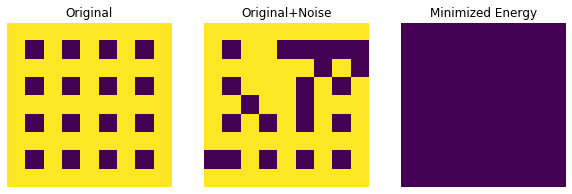

In [2]:
# test the algorithm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# create a small test image (diagonal line)
img = np.ones((9,9))

for rInd in range(len(img)):
    for cInd in range(len(img[0])):
        if (((rInd+1)%2) > 0) or (((cInd+1)%2) > 0):
            img[rInd,cInd] = -1
        
img = -img

# make a copy to add noise to
y = np.copy(img)

# iterate over pixels and randomly flip pixel values
for rInd in range(len(y)):
    for cInd in range(len(y[0])):
        change = np.random.binomial(1,0.1) # sample from a binomial distribution, with 10% chance > 0
        if change > 0:                     # based on sample,
            y[rInd,cInd] = -1*y[rInd,cInd] # flip pixel

# energy equation parameters
b = 1.0 # beta
n = 2.1 # eta
h = 0.0 # h

# initialize reconstruction from noisy image
x = np.copy(y)

# calculate original energy
print("Original energy: ",totalEnergy(img,img,h,b,n))

# calculate the energy of the noisy image
print("Energy before: ",totalEnergy(x,y,h,b,n))

# minimize the energy of the image
x = minEnergy(x,y,h,b,n,100)

# calculate the energy of the reconstructed image
print("Energy after: ",totalEnergy(x,y,h,b,n))

# plot starter image
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

# plot noisy image
plt.subplot(1,3,2)
plt.imshow(y)
plt.title("Original+Noise")
plt.axis('off')

# plot reconstructed image
plt.subplot(1,3,3)
plt.imshow(x)
plt.title("Minimized Energy")
plt.axis('off')
plt.show()

While this does minimize the energy, it clearly is not designed around de-noising images with this heavily-edged structure. We will revisit this later.

1.3 (10 pts) Illustrate the model by plot of the image as it is being de-noised at the beginning, middle, and end of the updating.  Choose images that aren't too high resolution so that the individual pixels are visible as squaures.  You may also do a live plot in a notebook to show it updating continuously, but make sure you have the static plots too in case the dynamic plot has portability issues.

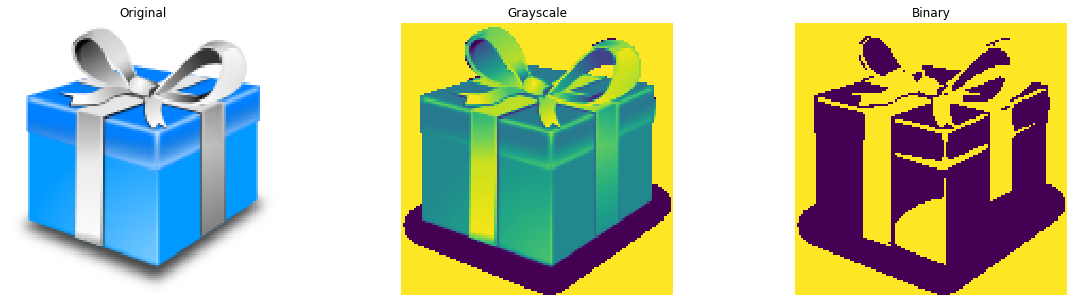

In [3]:
# image conditioning

import matplotlib.cbook as cbook

# read in a sample image from matplotlib
with cbook.get_sample_data('Minduka_Present_Blue_Pack.png') as image_file:
    image = plt.imread(image_file)

# convert the image to grayscale
rgb_weights = [0.2989, 0.5870, 0.1140]
grayscale_image = np.dot(image[...,:3], rgb_weights)

# convert the grayscale image into a binary one with pixel values of [-1,1]
binary_image = np.copy(grayscale_image)
for rInd in range(len(binary_image)):
    for cInd in range(len(binary_image[0])):
        if binary_image[rInd,cInd] > 0.6:
            binary_image[rInd,cInd] = 1
        else:
            binary_image[rInd,cInd] = -1
            
# plot the original image
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original")
plt.axis('off')

# plot the greyscale image
plt.subplot(1,3,2)
plt.imshow(grayscale_image)
plt.title("Grayscale")
plt.axis('off')

# plot the binary image
plt.subplot(1,3,3)
plt.imshow(binary_image)
plt.title("Binary")
plt.axis('off')
plt.show()

Original energy:  -92678.4
Energy before:  -72598.4
Energy after:  -87102.8


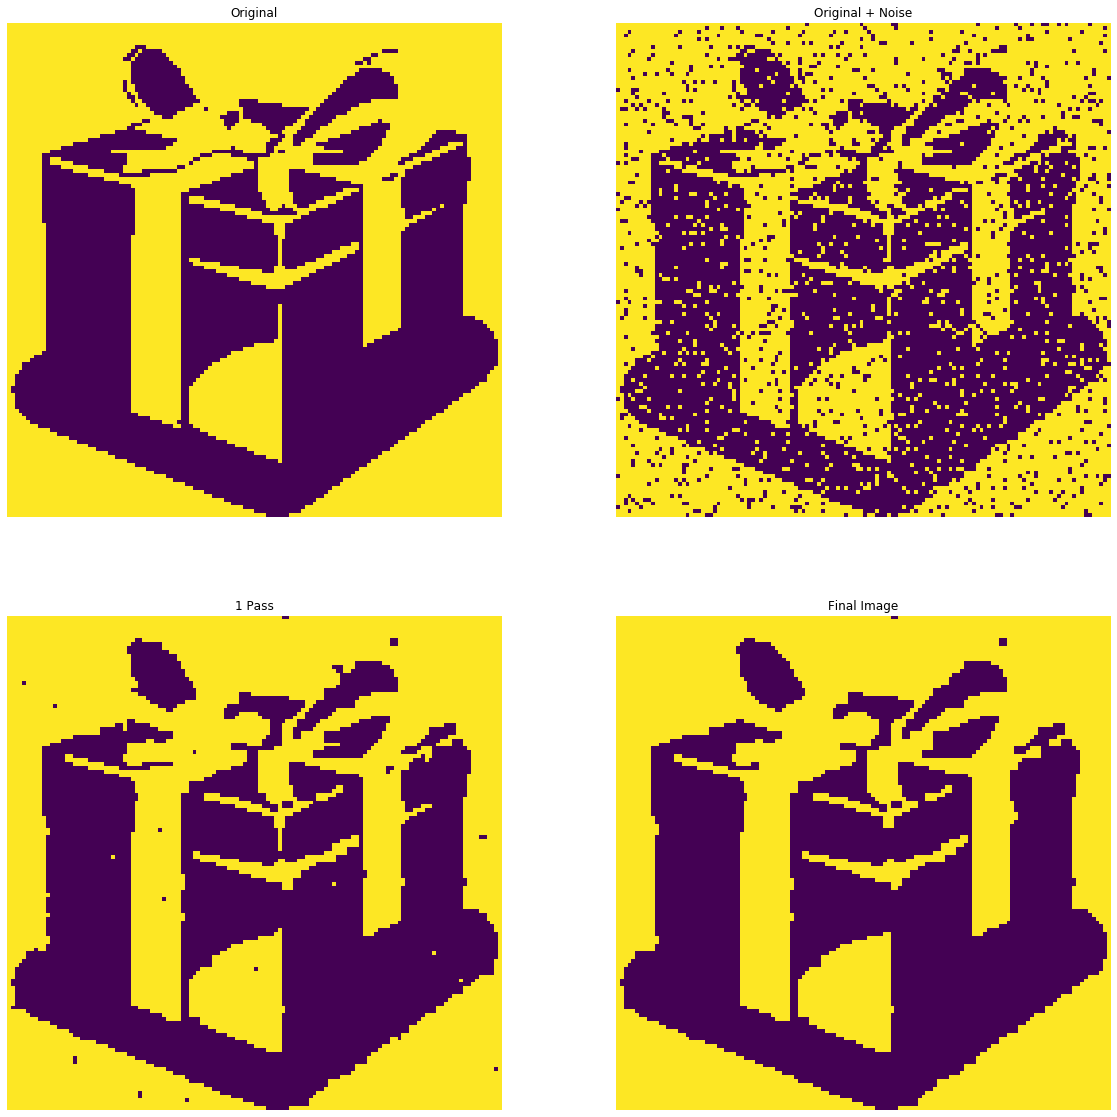

In [4]:
# make the image noisy

# plot the original image
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(binary_image)
plt.title("Original")
plt.axis('off')

# create a copy of the original image
y = np.copy(binary_image)

# iterate over pixels in image
for rInd in range(len(y)):
    for cInd in range(len(y[0])):
        change = np.random.binomial(1,0.1) # sample from a binomial distribution, with 10% chance > 0
        if change > 0:                     # based on sample,
            y[rInd,cInd] = -1*y[rInd,cInd] # flip pixel

# plot the noisy image
plt.subplot(2,2,2)
plt.imshow(y)
plt.title("Original + Noise")
plt.axis('off')

# initialize our reconstruction as a copy of the noisy image
x = np.copy(y)

# calculate original energy
print("Original energy: ",totalEnergy(binary_image,binary_image,h,b,n))

# calculate the original energy of the image
print("Energy before: ",totalEnergy(x,y,h,b,n))

# minimize the energy, doing only one raster over every pixel
x = minEnergy(x,y,h,b,n,1)

# plot the result over one pass
plt.subplot(2,2,3)
plt.imshow(x)
plt.title("1 Pass")
plt.axis('off')

# finish minimizing the energy
x = minEnergy(x,y,h,b,n,100)

# plot the reconstructed image
plt.subplot(2,2,4)
plt.imshow(x)
plt.title("Final Image")
plt.axis('off')

# calculate the energy of the final image
print("Energy after: ",totalEnergy(x,y,h,b,n))

plt.show()

While this method works fairly well, thin edges are quickly lost (as seen clearly in the bow above the present).

1.4 (5 pts) Experiment with different settings of the energy equation parameters and explain your results.

In the following code, I vary $\beta, \eta$ and h. The reconstructed images after 100 raster passes are shown below.

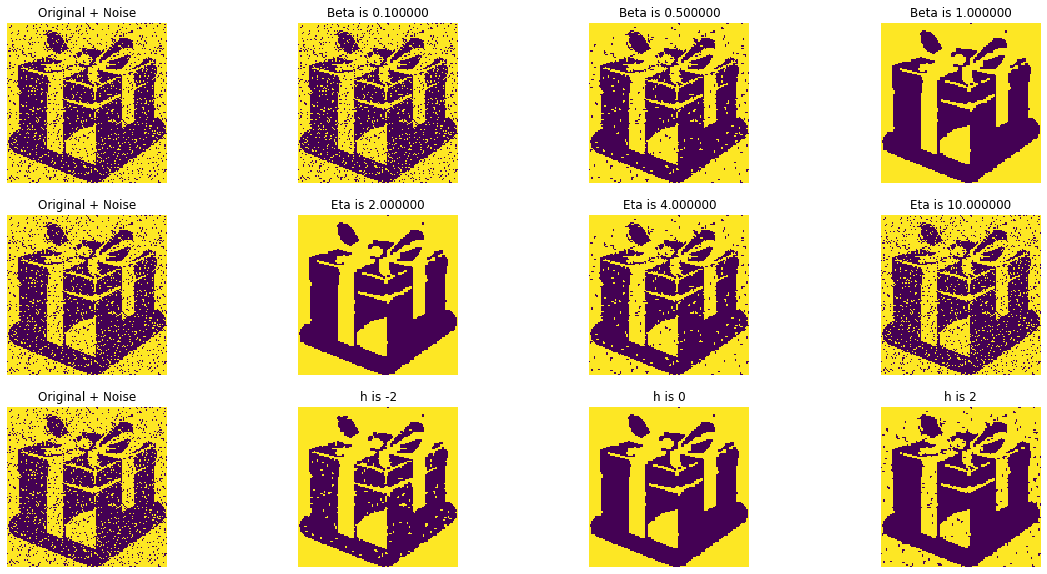

In [5]:
plt.figure(figsize=(20,10))

# vary beta
b = [0.1,0.5,1.0] # beta
n = 2.1 # eta
h = 0.0 # h

# plot the noisy image
plt.subplot(3,4,1)
plt.imshow(y)
plt.title("Original + Noise")
plt.axis('off')

for i in range(len(b)):
    # initialize our reconstruction as a copy of the noisy image
    x = np.copy(y)

    # finish minimizing the energy
    x = minEnergy(x,y,h,b[i],n,100)

    # plot the reconstructed image
    plt.subplot(3,4,i+2)
    plt.imshow(x)
    plt.title("Beta is %f" % b[i])
    plt.axis('off')

# vary eta
b = 1.0 # beta
n = [2.0,4.0,10.0] # eta
h = 0.0 # h

# plot the noisy image
plt.subplot(3,4,5)
plt.imshow(y)
plt.title("Original + Noise")
plt.axis('off')

for i in range(len(n)):
    # initialize our reconstruction as a copy of the noisy image
    x = np.copy(y)

    # finish minimizing the energy
    x = minEnergy(x,y,h,b,n[i],100)

    # plot the reconstructed image
    plt.subplot(3,4,i+6)
    plt.imshow(x)
    plt.title("Eta is %f" % n[i])
    plt.axis('off')


# vary h
b = 1.0 # beta
n = 2.1 # eta
h = [-2.0,0.0,2.0] # h

# plot the noisy image
plt.subplot(3,4,9)
plt.imshow(y)
plt.title("Original + Noise")
plt.axis('off')

for i in range(len(h)):
    # initialize our reconstruction as a copy of the noisy image
    x = np.copy(y)

    # finish minimizing the energy
    x = minEnergy(x,y,h[i],b,n,100)

    # plot the reconstructed image
    plt.subplot(3,4,i+10)
    plt.imshow(x)
    plt.title("h is %d" % h[i])
    plt.axis('off')


$\beta$ weights the algorithm to make adjacent pixels the same sign, so as the magnitude increases the different areas of the image become more defined. $\eta$ weights the probability of the base image having the same sign as the noise, so the higher the value the less noise that is removed. Finally h biases the liklihood of pikels being light or dark, so with negative values the algorithm prefers to make pixels lighter, and with positive values it prefers to darken pixels. A value of 0 causes the possibility of light or dark to be evenly weighted.

1.5 (10 pts)  Generalize the energy equation so that the model considers more that just pairs of pixels.  Explain your rationale behind this new model. Illustrate it with denoising examples (other types of images) with are not well-handled by the previous model.

In the original energy equation,

$$ E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_i\sum_{j\in \textrm{ne}(i)} x_i x_j - \eta \sum_i x_i y_i \quad(1)$$

the algorithm's preference is shown in the second term,

$$- \beta \sum_i\sum_{j\in \textrm{ne}(i)} x_i x_j.$$

This term causes the algorithm to have a higher probability of forcing a pixel to match the value of its surrounding neighbors (see "Block Kernel" in the generated image below). This means that the sum of the neighborhood around the pixel is

$$x_ix_{above} + x_ix_{right} + x_ix_{below} + x_ix_{left}.$$

In the original algorithm, large areas of uniform color are preserved while thin edges tend to be lost. In order to attempt to preserve these edges, I modified the original term by multiplying the original "Block" kernel by kernels for horizontal and vertical edges. This means that the neighborhood in the second term becomes

$$(x_ix_{above} + x_ix_{right} + x_ix_{below} + x_ix_{left})*(x_ix_{above} - x_ix_{right} + x_ix_{below} - x_ix_{left})*(-x_ix_{above} + x_ix_{right} - x_ix_{below} + x_ix_{left}).$$

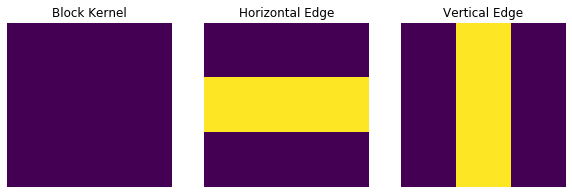

In [6]:
kernel_old = np.ones((3,3))
kernel_hedge = np.copy(kernel_old)
kernel_vedge = np.copy(kernel_old)

kernel_hedge[0,:] = -1
kernel_hedge[2,:] = -1
kernel_vedge[:,0] = -1
kernel_vedge[:,2] = -1

# plot starter image
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(kernel_old)
plt.title("Block Kernel")
plt.axis('off')

# plot noisy image
plt.subplot(1,3,2)
plt.imshow(kernel_hedge)
plt.title("Horizontal Edge")
plt.axis('off')

# plot reconstructed image
plt.subplot(1,3,3)
plt.imshow(kernel_vedge)
plt.title("Vertical Edge")
plt.axis('off')
plt.show()

We can now implement the change to the algorithm, and test again on the grid image from before.

In [7]:
def sumNeighbor(x,rInd,cInd):
    ## this part is the same as before...
    # sum(x_i x_j) for j in the neighborhood of i
    # the neighborhood is the adjacent pixels above, below, to the left and to the right of the source pixel
    
    # handle indices getting out of range
    if len(x) == (rInd+1):
        bot = x[0,cInd]
    else:
        bot = x[rInd+1,cInd]
        
    if len(x[0]) == (cInd+1):
        rit = x[rInd,0]
    else:
        rit = x[rInd,cInd+1]
        
    top = x[rInd-1,cInd]
    lft = x[rInd,cInd-1]
    ## ... all the way to here
    
    # NEW STUFF
    #sum neighbors
    total = (top+bot-lft-rit)*(top+bot+lft+rit)*(-top-bot+lft+rit)
    return total

Original energy:  -42.099999999999994
Energy before:  -122.1
Energy after:  -414.5


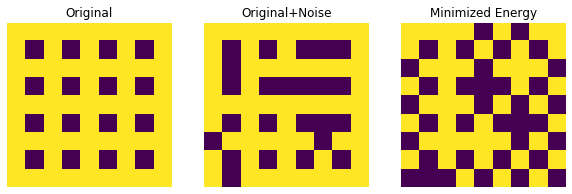

In [8]:
# test the algorithm

# create a small test image (diagonal line)
img = np.ones((9,9))

for rInd in range(len(img)):
    for cInd in range(len(img[0])):
        if (((rInd+1)%2) > 0) or (((cInd+1)%2) > 0):
            img[rInd,cInd] = -1.0
        
img = -img

# make a copy to add noise to
y = np.copy(img)

# iterate over pixels and randomly flip pixel values
for rInd in range(len(y)):
    for cInd in range(len(y[0])):
        change = np.random.binomial(1,0.1) # sample from a binomial distribution, with 10% chance > 0
        if change > 0:                     # based on sample,
            y[rInd,cInd] = -1*y[rInd,cInd] # flip pixel

# energy equation parameters
b = 1.0 # beta
n = 2.1 # eta
h = 0.0 # h

# calculate original energy
print("Original energy: ",totalEnergy(img,img,h,b,n))

# initialize reconstruction from noisy image
x = np.copy(y)

# calculate the energy of the noisy image
print("Energy before: ",totalEnergy(x,y,h,b,n))

# minimize the energy of the image
x = minEnergy(x,y,h,b,n,100)

# calculate the energy of the reconstructed image
print("Energy after: ",totalEnergy(x,y,h,b,n))

# plot starter image
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

# plot noisy image
plt.subplot(1,3,2)
plt.imshow(y)
plt.title("Original+Noise")
plt.axis('off')

# plot reconstructed image
plt.subplot(1,3,3)
plt.imshow(x)
plt.title("Minimized Energy")
plt.axis('off')
plt.show()

While the result is not perfect, this modified version of the algorithm creates a more grid-like final image than the original algorithm. Now let us see how the algorithm behaves with the more feature-rich present image.

Original energy:  -20758.4
Energy before:  -2374.4000000000015
Energy after:  -43204.4


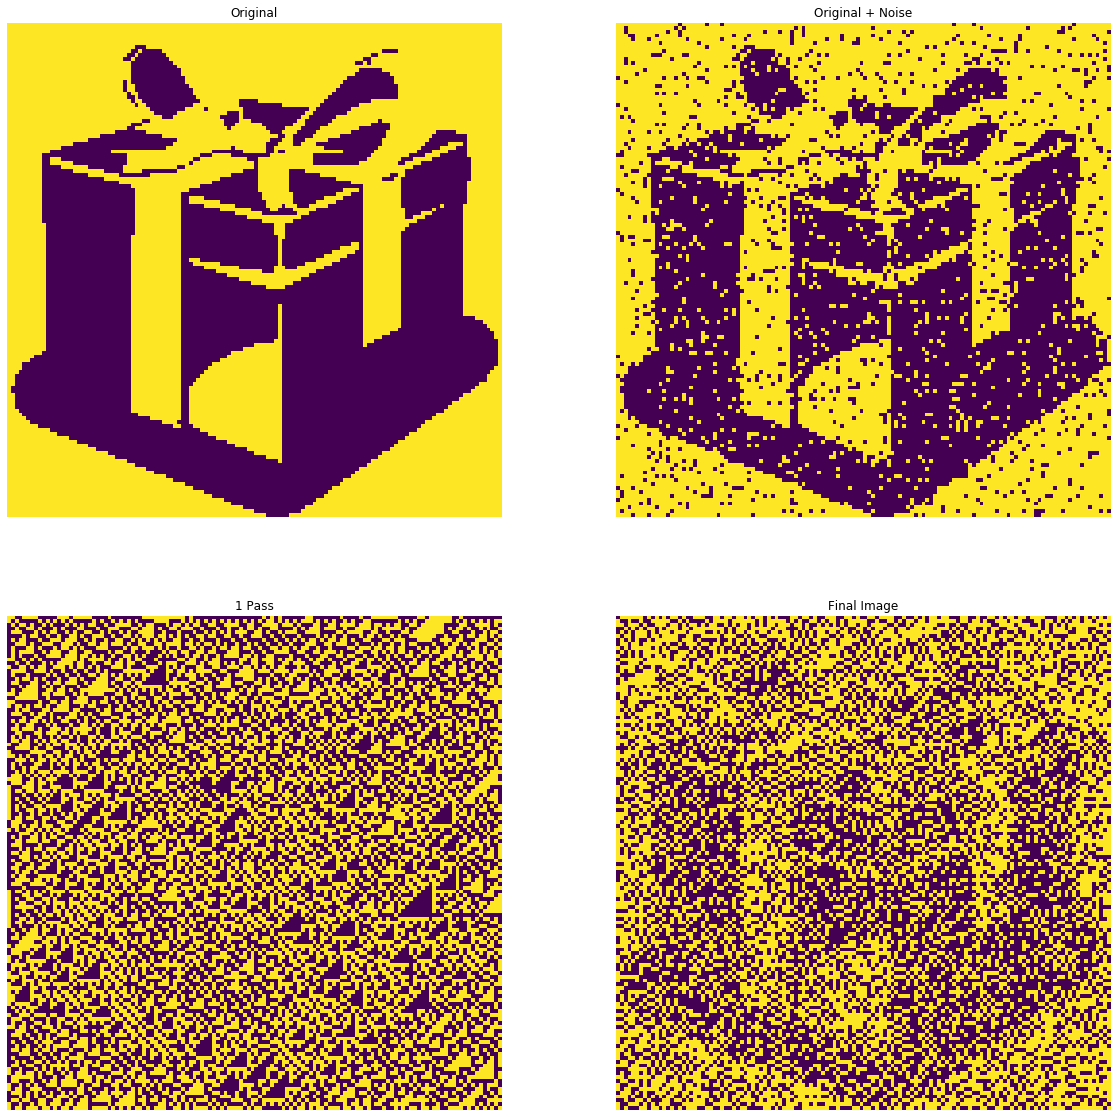

In [9]:
# make the image noisy

# plot the original image
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(binary_image)
plt.title("Original")
plt.axis('off')

# create a copy of the original image
y = np.copy(binary_image)

# iterate over pixels in image
for rInd in range(len(y)):
    for cInd in range(len(y[0])):
        change = np.random.binomial(1,0.1) # sample from a binomial distribution, with 10% chance > 0
        if change > 0:                     # based on sample,
            y[rInd,cInd] = -1*y[rInd,cInd] # flip pixel

# plot the noisy image
plt.subplot(2,2,2)
plt.imshow(y)
plt.title("Original + Noise")
plt.axis('off')

# initialize our reconstruction as a copy of the noisy image
x = np.copy(y)

# calculate original energy
print("Original energy: ",totalEnergy(binary_image,binary_image,h,b,n))

# calculate the original energy of the image
print("Energy before: ",totalEnergy(x,y,h,b,n))

# minimize the energy, doing only one raster over every pixel
x = minEnergy(x,y,h,b,n,1)

# plot the result over one pass
plt.subplot(2,2,3)
plt.imshow(x)
plt.title("1 Pass")
plt.axis('off')

# finish minimizing the energy
x = minEnergy(x,y,h,b,n,100)

# plot the reconstructed image
plt.subplot(2,2,4)
plt.imshow(x)
plt.title("Final Image")
plt.axis('off')

# calculate the energy of the final image
print("Energy after: ",totalEnergy(x,y,h,b,n))

plt.show()

As can clearly be seen, this algorithm does not perform very well at all at removing noise from the gift image. However, the behavior is extremely interesting. After one raster pass through the image, seemingly all information is lost from the original image, and the whole image consists of differently sized triangles. After many more passes (100 as shown for fast recompilation, although up to 10000 passes were tried), the original image starts to re-emerge from the intense pattern. While this algorithm doesn't do a good job of removing noise, it does *seem* to be able to turn a normal image into a Bev Doolittle-esque camouflage painting.

### Exercise 2. Graphical Representation (15 points)

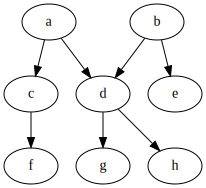

In [10]:
from graphviz import Digraph

q1 = Digraph()
q1.node('a') # variable name, label
q1.node('b')
q1.node('c')
q1.node('d')
q1.node('e')
q1.node('f')
q1.node('g')
q1.node('h')
q1.edges(['ac', 'ad', 'bd', 'be', 'cf', 'dg', 'dh'])
# render inline
q1

2.1 (5 pts) For the Bayesian network show above, draw the corresponding Markov Random Field (MRF), and write out the joint probability using potential functions.  You do not need to specify the functions themselves, only which arguments they take.

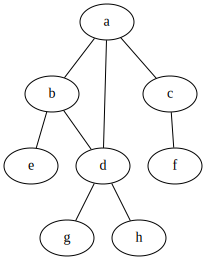

In [11]:
from graphviz import Graph

q1m = Graph()
q1m.node('a')
q1m.node('b')
q1m.node('c')
q1m.node('d')
q1m.node('e')
q1m.node('f')
q1m.node('g')
q1m.node('h')
q1m.edges(['ab', 'ad', 'bd', 'ac', 'be', 'cf', 'dg', 'dh'])
# render inline
q1m

The Markov Random Field which represents the directed bayesian network is depicted above. When converting a directed to an undirected representation, the original relationship between a,b, and d cannot be directly represented. So, an edge is added to represent the relationship between a and b. Otherwise, all edges just have their directionality removed. Writing this MRF as the product of clique potential functions is

$$p(X) = \frac{1}{Z}\psi(a,b,d)\psi(a,c)\psi(b,e)\psi(c,f)\psi(d,g)\psi(d,h)$$

2.2 (5 pts) Now specify the Bayes net as a factor graph.  Again write the expression for the joint probability, but using factor functions.

Writing the original bayesian network, we get the following product of conditional probabilities:

$$p(X) = p(f|c)p(g|d)p(h|d)p(c|a)p(d|a,b)p(e|b)p(a)p(b).$$

Rewriting as a factor graph, we get

$$p(X) = f_f(c,f)f_g(d,g)f_h(d,h)f_c(a,c)f_d(a,b,d)f_e(b,e)f_a(a)f_b(b)$$

with the factor graph displayed below.

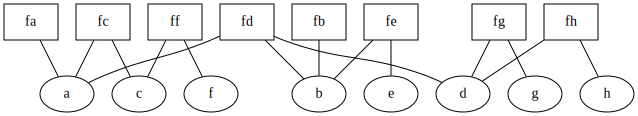

In [12]:
q1f = Graph()
q1f.node('a')
q1f.node('b')
q1f.node('c')
q1f.node('d')
q1f.node('e')
q1f.node('f')
q1f.node('g')
q1f.node('h')

q1f.attr('node', shape='box')
q1f.node('fa')
q1f.node('fb')
q1f.node('fc')
q1f.node('fd')
q1f.node('fe')
q1f.node('ff')
q1f.node('fg')
q1f.node('fh')

q1f.edge('fa','a')
q1f.edge('fb','b')
q1f.edge('fc','a')
q1f.edge('fc','c')
q1f.edge('fd','a')
q1f.edge('fd','b')
q1f.edge('fd','d')
q1f.edge('fe','b')
q1f.edge('fe','e')
q1f.edge('ff','c')
q1f.edge('ff','f')
q1f.edge('fg','d')
q1f.edge('fg','g')
q1f.edge('fh','d')
q1f.edge('fh','h')

q1f

2.3 (5 pts) Express the following Bayes net (from the sprinkler example) in two different factor graphs.  For each network, write the factors as a function of the conditional probabilties and specify the joint probability.

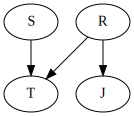

In [13]:
q2 = Digraph()
q2.node('S') # variable name, label
q2.node('R')
q2.node('T')
q2.node('J')
q2.edges(['ST', 'RT', 'RJ'])
# render inline
q2

The above network models the joint probability

$$p(X) = p(S)p(R)p(T|S,R)p(J|R).$$

One way of expressing the above network as a factor graph is

$$p(X) = f_S(S)f_R(R)f_T(R,S,T)f_J(J,R),$$

where

$$f_S(S) = p(S),$$

$$f_R(R) = p(R),$$

$$f_T(R,S,T) = p(T|R,S),$$

$$f_J(J,R) = p(J|R).$$

The factor graph is shown below.

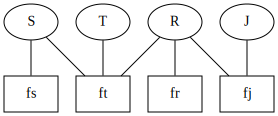

In [14]:
q21 = Graph()
q21.node('S')
q21.node('R')
q21.node('T')
q21.node('J')

q21.attr('node', shape='box')
q21.node('fs')
q21.node('ft')
q21.node('fj')
q21.node('fr')

q21.edge('S','fs')
q21.edge('S','ft')
q21.edge('R','ft')
q21.edge('T','ft')
q21.edge('R','fr')
q21.edge('R','fj')
q21.edge('J','fj')

q21

Another way of expressing the above network as a factor graph is

$$p(X) = f_T(R,S,T)f_J(J,R),$$

where

$$f_T(R,S,T) = p(R)p(S)p(T|R,S),$$

$$f_J(J,R) = p(J|R).$$

This representation is more condensed than the previous version we wrote. The factor graph is shown below.

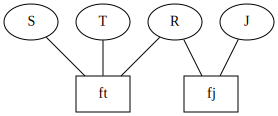

In [15]:
q22 = Graph()
q22.node('S')
q22.node('R')
q22.node('T')
q22.node('J')

q22.attr('node', shape='box')
q22.node('ft')
q22.node('fj')

q22.edge('S','ft')
q22.edge('R','ft')
q22.edge('T','ft')
q22.edge('R','fj')
q22.edge('J','fj')

q22

### Exercise 3. The Sum Product Algorithm (25 pts)

Consider the following factor graph.

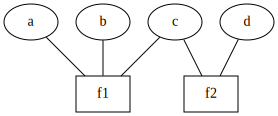

In [16]:
q3 = Graph()
q3.node('a')
q3.node('b')
q3.node('c')
q3.node('d')

q3.attr('node',shape='box')
q3.node('f1')
q3.node('f2')

q3.edge('a','f1')
q3.edge('b','f1')
q3.edge('c','f1')
q3.edge('c','f2')
q3.edge('d','f2')

q3

3.1 (10 pts) Apply the sum-product algorithm to compute the all messages when none of the variables are known.

Joint probability:

$$p(x) = f_1(a,b,c)f_2(c,d).$$

First set of messages:

$$\mu_{a\rightarrow f_1}(a) = 1,$$

$$\mu_{b\rightarrow f_1}(b) = 1,$$

$$\mu_{f_1\rightarrow c}(c) = \sum_a\sum_bf_1(a,b,c),$$

$$\mu_{c\rightarrow f_2}(c) = \mu_{f_1\rightarrow c}(c),$$

$$\mu_{f_2\rightarrow d}(d) = \sum_cf_2(c,d)\mu_{c\rightarrow f_2}(c).$$

Second set of messages:

$$\mu_{d\rightarrow d}(d) = 1,$$

$$\mu_{f_2\rightarrow c}(c) = \sum_df_2(c,d),$$

$$\mu_{c\rightarrow f_1}(c) = \mu_{f_2\rightarrow c}(c),$$

$$\mu_{f_1\rightarrow a}(a) = \sum_cf_1(a,b,c)\mu_{c\rightarrow f_1}(c),$$

$$\mu_{f_1\rightarrow b}(b) = \mu_{f_1\rightarrow a}(a).$$

3.2 (5 pts) Compute the marginal probability $p(c)$, expressing it in terms of the messages you derived in the previous question.

$$p(c) = \mu_{f_1\rightarrow c}(c)\mu_{f_2\rightarrow c}(c)$$

3.3 (5 pts) Verify that the marginal is the correct expression substituting in the message definitions.

$$p(c) = \mu_{f_1\rightarrow c}(c)\mu_{f_2\rightarrow c}(c),$$

$$p(c) = \left[\sum_a\sum_bf_1(a,b,c)\right]\left[\sum_df_2(c,d)\right],$$

$$p(c) = \sum_a\sum_b\sum_df_1(a,b,c)f_2(c,d),$$

$$p(c) = \sum_a\sum_b\sum_dp(x).$$

Now consider adding a loop to the graph.

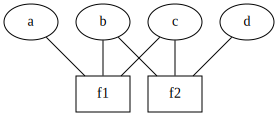

In [17]:
q4 = Graph()
q4.node('a')
q4.node('b')
q4.node('c')
q4.node('d')

q4.attr('node',shape='box')
q4.node('f1')
q4.node('f2')

q4.edge('a','f1')
q4.edge('b','f1')
q4.edge('c','f1')
q4.edge('c','f2')
q4.edge('d','f2')
q4.edge('b','f2')

q4

3.4 (5 pts) Explore the consequences of applying the sum-product algorithm to this graph. Can the algorithm still be applied?

As the graph above is presented, the application of the sum-product to a cyclic graph is more difficult than in the acyclic case. In a cyclic graph there is no way to obtain the message $\mu_{f_1\rightarrow c}(c)$ because $f_1$ and $f_2$ are dependent on each other. The most analytically straightforward method to resolve this issue is to convert the factor graph into a representation which is acyclic. Using the method presented in \[Kschischang et al 2001\], we can cluster $b$ and $c$ into one node and appropriately modify $f_1$ and $f_2$, such that the graph is no longer cyclic.

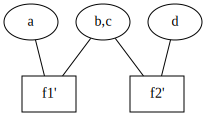

In [18]:
q4a = Graph()
q4a.node('a')
q4a.node('b,c')
q4a.node('d')

q4a.attr('node',shape='box')
q4a.node('f1\'')
q4a.node('f2\'')

q4a.edge('a','f1\'')
q4a.edge('b,c','f1\'')
q4a.edge('b,c','f2\'')
q4a.edge('d','f2\'')

q4a

Another approach would be to solve the graph in an iterative matter, starting with each outer message having a value of 1. Eventually this will converge to the correct message values.

Reference:
Kschischang, Frank R., Frey, Brendan J., Loeliger, H-A. "Factor graphs and the sum-product algorithm." *IEEE Transactions on information theory* 47.2 (2001): 498-519

### Exploration (20 points)

Select a topic from the readings (Barber chapters 4 and 5, Murphy chapters 19 and 20, or Bishop Chapter 8) and write your own exercise.  It should aim to teach or explore a concept you don't understand or found interesting.  Like before, you don't do an excessive amount of work.  This isn't a project.  Aim for something worth about 20 points, i.e. about half as much work has exercise 1 or a little more work than exercise 2.

Grading rubric:
- Clarity of explanation. Could another student read and do this? (5 pts)
- Novelty or distinctness. Does it complement or go beyond what was covered above? (5 pts)
- Does the exercise teach something about the concept(s)? (5 pts)
- How deeply does it explore the concept(s)? (5 pts)

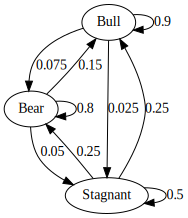

In [20]:
qStock = Digraph()
qStock.node('Bull')
qStock.node('Bear')
qStock.node('Stagnant')
qStock.edge('Bull','Bull',label='0.9')
qStock.edge('Bull','Bear',label='0.075')
qStock.edge('Bull','Stagnant',label='0.025')
qStock.edge('Bear','Bull',label='0.15')
qStock.edge('Bear','Bear',label='0.8')
qStock.edge('Bear','Stagnant',label='0.05')
qStock.edge('Stagnant','Bull',label='0.25')
qStock.edge('Stagnant','Bear',label='0.25')
qStock.edge('Stagnant','Stagnant',label='0.5')
qStock

In [43]:
def markovChain(M,V,n):
    output = np.copy(M)
    output = np.dot(output,V)
    for i in range(n-1):
        output = M@output
    
    return output

In [44]:
M = ([0.9  , 0.15, 0.25],
     [0.075, 0.8 , 0.25],
     [0.025, 0.05, 0.5])
V = ([0,1,0])
n = 3
output = markovChain(M,V,n)
print(output)

[0.3575  0.56825 0.07425]


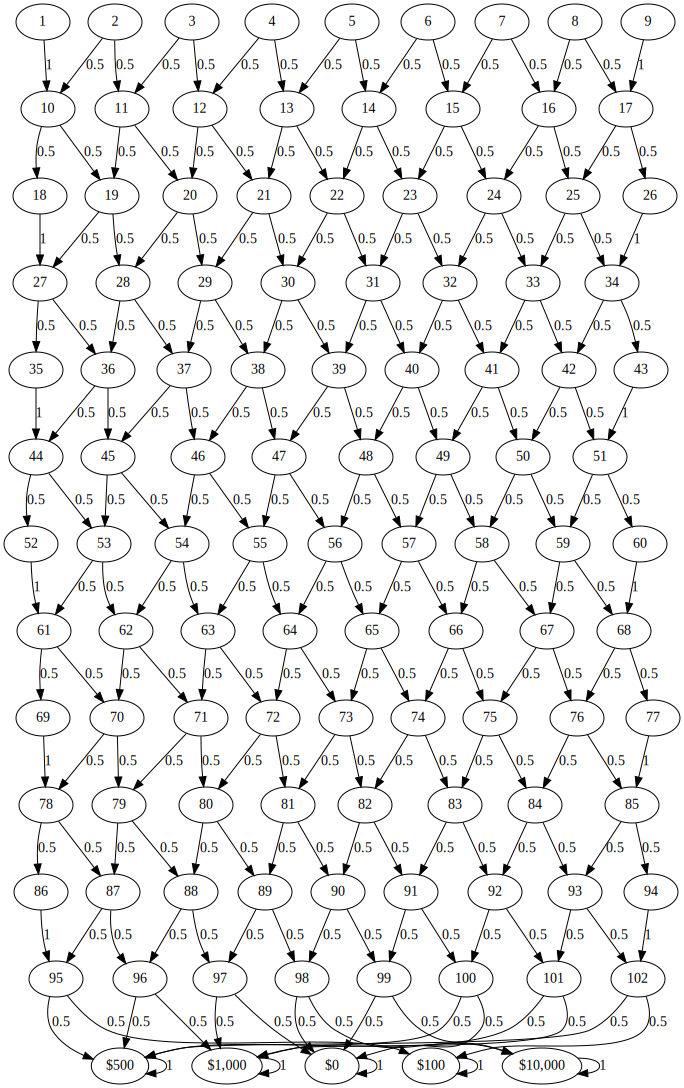

In [64]:
qPlinko = Digraph()
# nodes
qPlinko.node('1');qPlinko.node('2');qPlinko.node('3');qPlinko.node('4');qPlinko.node('5');qPlinko.node('6')
qPlinko.node('7');qPlinko.node('8');qPlinko.node('9');qPlinko.node('10');qPlinko.node('21');qPlinko.node('22');
qPlinko.node('23');qPlinko.node('24');qPlinko.node('25');qPlinko.node('26');qPlinko.node('27');qPlinko.node('28');
qPlinko.node('29');qPlinko.node('30');qPlinko.node('31');qPlinko.node('32');qPlinko.node('33');qPlinko.node('34');
qPlinko.node('35');qPlinko.node('36');qPlinko.node('37');qPlinko.node('38');qPlinko.node('39');qPlinko.node('40');
qPlinko.node('41');qPlinko.node('42');qPlinko.node('43');qPlinko.node('44');qPlinko.node('45');qPlinko.node('46');
qPlinko.node('47');qPlinko.node('48');qPlinko.node('49');qPlinko.node('50');qPlinko.node('51');qPlinko.node('52');
qPlinko.node('53');qPlinko.node('54');qPlinko.node('55');qPlinko.node('56');qPlinko.node('57');qPlinko.node('58');
qPlinko.node('59');qPlinko.node('60');qPlinko.node('61');qPlinko.node('62');qPlinko.node('63');qPlinko.node('64');
qPlinko.node('65');qPlinko.node('66');qPlinko.node('67');qPlinko.node('68');qPlinko.node('69');qPlinko.node('70');
qPlinko.node('71');qPlinko.node('72');qPlinko.node('73');qPlinko.node('74');qPlinko.node('75');qPlinko.node('76');
qPlinko.node('77');qPlinko.node('78');qPlinko.node('79');qPlinko.node('80');qPlinko.node('81');qPlinko.node('82');
qPlinko.node('83');qPlinko.node('84');qPlinko.node('85');qPlinko.node('86');qPlinko.node('87');qPlinko.node('88');
qPlinko.node('89');qPlinko.node('90');qPlinko.node('91');qPlinko.node('92');qPlinko.node('93');qPlinko.node('94');
qPlinko.node('95');qPlinko.node('96');qPlinko.node('97');qPlinko.node('98');qPlinko.node('99');qPlinko.node('100');
qPlinko.node('101');qPlinko.node('102');qPlinko.node('$100');qPlinko.node('$500');qPlinko.node('$1,000');
qPlinko.node('$0');qPlinko.node('$10,000');

# edges
qPlinko.edge('1','10',label="1");qPlinko.edge('2','10',label="0.5");qPlinko.edge('2','11',label="0.5");
qPlinko.edge('3','11',label="0.5");qPlinko.edge('3','12',label="0.5");qPlinko.edge('4','12',label="0.5");
qPlinko.edge('4','13',label="0.5");qPlinko.edge('5','13',label="0.5");qPlinko.edge('5','14',label="0.5");
qPlinko.edge('6','14',label="0.5");qPlinko.edge('6','15',label="0.5");qPlinko.edge('7','15',label="0.5");
qPlinko.edge('7','16',label="0.5");qPlinko.edge('8','16',label="0.5");qPlinko.edge('8','17',label="0.5");
qPlinko.edge('9','17',label="1");qPlinko.edge('10','18',label="0.5");qPlinko.edge('10','19',label="0.5");
qPlinko.edge('11','19',label="0.5");qPlinko.edge('11','20',label="0.5");qPlinko.edge('12','20',label="0.5");
qPlinko.edge('12','21',label="0.5");qPlinko.edge('13','21',label="0.5");qPlinko.edge('13','22',label="0.5");
qPlinko.edge('14','22',label="0.5");qPlinko.edge('14','23',label="0.5");qPlinko.edge('15','23',label="0.5");
qPlinko.edge('15','24',label="0.5");qPlinko.edge('16','24',label="0.5");qPlinko.edge('16','25',label="0.5");
qPlinko.edge('17','25',label="0.5");qPlinko.edge('17','26',label="0.5");qPlinko.edge('18','27',label="1");
qPlinko.edge('19','27',label="0.5");qPlinko.edge('19','28',label="0.5");qPlinko.edge('20','28',label="0.5");
qPlinko.edge('20','29',label="0.5");qPlinko.edge('21','29',label="0.5");qPlinko.edge('21','30',label="0.5");
qPlinko.edge('22','30',label="0.5");qPlinko.edge('22','31',label="0.5");qPlinko.edge('23','31',label="0.5");
qPlinko.edge('23','32',label="0.5");qPlinko.edge('24','32',label="0.5");qPlinko.edge('24','33',label="0.5");
qPlinko.edge('25','33',label="0.5");qPlinko.edge('25','34',label="0.5");qPlinko.edge('26','34',label="1");
qPlinko.edge('27','35',label="0.5");qPlinko.edge('27','36',label="0.5");qPlinko.edge('28','36',label="0.5");
qPlinko.edge('28','37',label="0.5");qPlinko.edge('29','37',label="0.5");qPlinko.edge('29','38',label="0.5");
qPlinko.edge('30','38',label="0.5");qPlinko.edge('30','39',label="0.5");qPlinko.edge('31','39',label="0.5");
qPlinko.edge('31','40',label="0.5");qPlinko.edge('32','40',label="0.5");qPlinko.edge('32','41',label="0.5");
qPlinko.edge('33','41',label="0.5");qPlinko.edge('33','42',label="0.5");qPlinko.edge('34','42',label="0.5");
qPlinko.edge('34','43',label="0.5");qPlinko.edge('35','44',label="1");qPlinko.edge('36','44',label="0.5");
qPlinko.edge('36','45',label="0.5");qPlinko.edge('37','45',label="0.5");qPlinko.edge('37','46',label="0.5");
qPlinko.edge('38','46',label="0.5");qPlinko.edge('38','47',label="0.5");qPlinko.edge('39','47',label="0.5");
qPlinko.edge('39','48',label="0.5");qPlinko.edge('40','48',label="0.5");qPlinko.edge('40','49',label="0.5");
qPlinko.edge('41','49',label="0.5");qPlinko.edge('41','50',label="0.5");qPlinko.edge('42','50',label="0.5");
qPlinko.edge('42','51',label="0.5");qPlinko.edge('43','51',label="1");qPlinko.edge('44','52',label="0.5");
qPlinko.edge('44','53',label="0.5");qPlinko.edge('45','53',label="0.5");qPlinko.edge('45','54',label="0.5");
qPlinko.edge('46','54',label="0.5");qPlinko.edge('46','55',label="0.5");qPlinko.edge('47','55',label="0.5");
qPlinko.edge('47','56',label="0.5");qPlinko.edge('48','56',label="0.5");qPlinko.edge('48','57',label="0.5");
qPlinko.edge('49','57',label="0.5");qPlinko.edge('49','58',label="0.5");qPlinko.edge('50','58',label="0.5");
qPlinko.edge('50','59',label="0.5");qPlinko.edge('51','59',label="0.5");qPlinko.edge('51','60',label="0.5");
qPlinko.edge('52','61',label="1");qPlinko.edge('53','61',label="0.5");qPlinko.edge('53','62',label="0.5");
qPlinko.edge('54','62',label="0.5");qPlinko.edge('54','63',label="0.5");qPlinko.edge('55','63',label="0.5");
qPlinko.edge('55','64',label="0.5");qPlinko.edge('56','64',label="0.5");qPlinko.edge('56','65',label="0.5");
qPlinko.edge('57','65',label="0.5");qPlinko.edge('57','66',label="0.5");qPlinko.edge('58','66',label="0.5");
qPlinko.edge('58','67',label="0.5");qPlinko.edge('59','67',label="0.5");qPlinko.edge('59','68',label="0.5");
qPlinko.edge('60','68',label="1");qPlinko.edge('61','69',label="0.5");qPlinko.edge('61','70',label="0.5");
qPlinko.edge('62','70',label="0.5");qPlinko.edge('62','71',label="0.5");qPlinko.edge('63','71',label="0.5");
qPlinko.edge('63','72',label="0.5");qPlinko.edge('64','72',label="0.5");qPlinko.edge('64','73',label="0.5");
qPlinko.edge('65','73',label="0.5");qPlinko.edge('65','74',label="0.5");qPlinko.edge('66','74',label="0.5");
qPlinko.edge('66','75',label="0.5");qPlinko.edge('67','75',label="0.5");qPlinko.edge('67','76',label="0.5");
qPlinko.edge('68','76',label="0.5");qPlinko.edge('68','77',label="0.5");qPlinko.edge('69','78',label="1");
qPlinko.edge('70','78',label="0.5");qPlinko.edge('70','79',label="0.5");qPlinko.edge('71','79',label="0.5");
qPlinko.edge('71','80',label="0.5");qPlinko.edge('72','80',label="0.5");qPlinko.edge('72','81',label="0.5");
qPlinko.edge('73','81',label="0.5");qPlinko.edge('73','82',label="0.5");qPlinko.edge('74','82',label="0.5");
qPlinko.edge('74','83',label="0.5");qPlinko.edge('75','83',label="0.5");qPlinko.edge('75','84',label="0.5");
qPlinko.edge('76','84',label="0.5");qPlinko.edge('76','85',label="0.5");qPlinko.edge('77','85',label="1");
qPlinko.edge('78','86',label="0.5");qPlinko.edge('78','87',label="0.5");qPlinko.edge('79','87',label="0.5");
qPlinko.edge('79','88',label="0.5");qPlinko.edge('80','88',label="0.5");qPlinko.edge('80','89',label="0.5");
qPlinko.edge('81','89',label="0.5");qPlinko.edge('81','90',label="0.5");qPlinko.edge('82','90',label="0.5");
qPlinko.edge('82','91',label="0.5");qPlinko.edge('83','91',label="0.5");qPlinko.edge('83','92',label="0.5");
qPlinko.edge('84','92',label="0.5");qPlinko.edge('84','93',label="0.5");qPlinko.edge('85','93',label="0.5");
qPlinko.edge('85','94',label="0.5");qPlinko.edge('86','95',label="1");qPlinko.edge('87','95',label="0.5");
qPlinko.edge('87','96',label="0.5");qPlinko.edge('88','96',label="0.5");qPlinko.edge('88','97',label="0.5");
qPlinko.edge('89','97',label="0.5");qPlinko.edge('89','98',label="0.5");qPlinko.edge('90','98',label="0.5");
qPlinko.edge('90','99',label="0.5");qPlinko.edge('91','99',label="0.5");qPlinko.edge('91','100',label="0.5");
qPlinko.edge('92','100',label="0.5");qPlinko.edge('92','101',label="0.5");qPlinko.edge('93','101',label="0.5");
qPlinko.edge('93','102',label="0.5");qPlinko.edge('94','102',label="1");qPlinko.edge('95','$100',label="0.5");
qPlinko.edge('95','$500',label="0.5");qPlinko.edge('96','$500',label="0.5");qPlinko.edge('96','$1,000',label="0.5");
qPlinko.edge('97','$1,000',label="0.5");qPlinko.edge('97','$0',label="0.5");qPlinko.edge('98','$0',label="0.5");
qPlinko.edge('98','$10,000',label="0.5");qPlinko.edge('99','$10,000',label="0.5");qPlinko.edge('99','$0',label="0.5");
qPlinko.edge('100','$0',label="0.5");qPlinko.edge('100','$1,000',label="0.5");qPlinko.edge('101','$1,000',label="0.5");
qPlinko.edge('101','$500',label="0.5");qPlinko.edge('102','$500',label="0.5");qPlinko.edge('102','$100',label="0.5");
qPlinko.edge('$100','$100',label="1");qPlinko.edge('$500','$500',label="1");qPlinko.edge('$1,000','$1,000',label="1");
qPlinko.edge('$10,000','$10,000',label="1");qPlinko.edge('$0','$0',label="1")

qPlinko

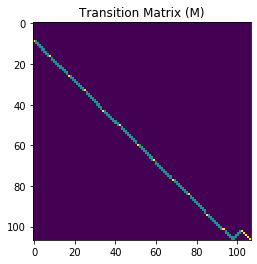

In [80]:
M = np.zeros((107,107))

M[9+(0*17),0+(0*17)]=1;M[9+(0*17),1+(0*17)]=0.5;M[10+(0*17),1+(0*17)]=0.5;M[10+(0*17),2+(0*17)]=0.5;
M[11+(0*17),2+(0*17)]=0.5;M[11+(0*17),3+(0*17)]=0.5;M[12+(0*17),3+(0*17)]=0.5;M[12+(0*17),4+(0*17)]=0.5;
M[13+(0*17),4+(0*17)]=0.5;M[13+(0*17),5+(0*17)]=0.5;M[14+(0*17),5+(0*17)]=0.5;M[14+(0*17),6+(0*17)]=0.5;
M[15+(0*17),6+(0*17)]=0.5;M[15+(0*17),7+(0*17)]=0.5;M[16+(0*17),7+(0*17)]=0.5;M[16+(0*17),8+(0*17)]=1;
M[17+(0*17),9+(0*17)]=0.5;M[18+(0*17),9+(0*17)]=0.5;M[18+(0*17),10+(0*17)]=0.5;M[19+(0*17),10+(0*17)]=0.5;
M[19+(0*17),11+(0*17)]=0.5;M[20+(0*17),11+(0*17)]=0.5;M[20+(0*17),12+(0*17)]=0.5;M[21+(0*17),12+(0*17)]=0.5;
M[21+(0*17),13+(0*17)]=0.5;M[22+(0*17),13+(0*17)]=0.5;M[22+(0*17),14+(0*17)]=0.5;M[23+(0*17),14+(0*17)]=0.5;
M[23+(0*17),15+(0*17)]=0.5;M[24+(0*17),15+(0*17)]=0.5;M[24+(0*17),16+(0*17)]=0.5;M[25+(0*17),16+(0*17)]=0.5;
M[9+(1*17),0+(1*17)]=1;M[9+(1*17),1+(1*17)]=0.5;M[10+(1*17),1+(1*17)]=0.5;M[10+(1*17),2+(1*17)]=0.5;
M[11+(1*17),2+(1*17)]=0.5;M[11+(1*17),3+(1*17)]=0.5;M[12+(1*17),3+(1*17)]=0.5;M[12+(1*17),4+(1*17)]=0.5;
M[13+(1*17),4+(1*17)]=0.5;M[13+(1*17),5+(1*17)]=0.5;M[14+(1*17),5+(1*17)]=0.5;M[14+(1*17),6+(1*17)]=0.5;
M[15+(1*17),6+(1*17)]=0.5;M[15+(1*17),7+(1*17)]=0.5;M[16+(1*17),7+(1*17)]=0.5;M[16+(1*17),8+(1*17)]=1;
M[17+(1*17),9+(1*17)]=0.5;M[18+(1*17),9+(1*17)]=0.5;M[18+(1*17),10+(1*17)]=0.5;M[19+(1*17),10+(1*17)]=0.5;
M[19+(1*17),11+(1*17)]=0.5;M[20+(1*17),11+(1*17)]=0.5;M[20+(1*17),12+(1*17)]=0.5;M[21+(1*17),12+(1*17)]=0.5;
M[21+(1*17),13+(1*17)]=0.5;M[22+(1*17),13+(1*17)]=0.5;M[22+(1*17),14+(1*17)]=0.5;M[23+(1*17),14+(1*17)]=0.5;
M[23+(1*17),15+(1*17)]=0.5;M[24+(1*17),15+(1*17)]=0.5;M[24+(1*17),16+(1*17)]=0.5;M[25+(1*17),16+(1*17)]=0.5;
M[9+(2*17),0+(2*17)]=1;M[9+(2*17),1+(2*17)]=0.5;M[10+(2*17),1+(2*17)]=0.5;M[10+(2*17),2+(2*17)]=0.5;
M[11+(2*17),2+(2*17)]=0.5;M[11+(2*17),3+(2*17)]=0.5;M[12+(2*17),3+(2*17)]=0.5;M[12+(2*17),4+(2*17)]=0.5;
M[13+(2*17),4+(2*17)]=0.5;M[13+(2*17),5+(2*17)]=0.5;M[14+(2*17),5+(2*17)]=0.5;M[14+(2*17),6+(2*17)]=0.5;
M[15+(2*17),6+(2*17)]=0.5;M[15+(2*17),7+(2*17)]=0.5;M[16+(2*17),7+(2*17)]=0.5;M[16+(2*17),8+(2*17)]=1;
M[17+(2*17),9+(2*17)]=0.5;M[18+(2*17),9+(2*17)]=0.5;M[18+(2*17),10+(2*17)]=0.5;M[19+(2*17),10+(2*17)]=0.5;
M[19+(2*17),11+(2*17)]=0.5;M[20+(2*17),11+(2*17)]=0.5;M[20+(2*17),12+(2*17)]=0.5;M[21+(2*17),12+(2*17)]=0.5;
M[21+(2*17),13+(2*17)]=0.5;M[22+(2*17),13+(2*17)]=0.5;M[22+(2*17),14+(2*17)]=0.5;M[23+(2*17),14+(2*17)]=0.5;
M[23+(2*17),15+(2*17)]=0.5;M[24+(2*17),15+(2*17)]=0.5;M[24+(2*17),16+(2*17)]=0.5;M[25+(2*17),16+(2*17)]=0.5;
M[9+(3*17),0+(3*17)]=1;M[9+(3*17),1+(3*17)]=0.5;M[10+(3*17),1+(3*17)]=0.5;M[10+(3*17),2+(3*17)]=0.5;
M[11+(3*17),2+(3*17)]=0.5;M[11+(3*17),3+(3*17)]=0.5;M[12+(3*17),3+(3*17)]=0.5;M[12+(3*17),4+(3*17)]=0.5;
M[13+(3*17),4+(3*17)]=0.5;M[13+(3*17),5+(3*17)]=0.5;M[14+(3*17),5+(3*17)]=0.5;M[14+(3*17),6+(3*17)]=0.5;
M[15+(3*17),6+(3*17)]=0.5;M[15+(3*17),7+(3*17)]=0.5;M[16+(3*17),7+(3*17)]=0.5;M[16+(3*17),8+(3*17)]=1;
M[17+(3*17),9+(3*17)]=0.5;M[18+(3*17),9+(3*17)]=0.5;M[18+(3*17),10+(3*17)]=0.5;M[19+(3*17),10+(3*17)]=0.5;
M[19+(3*17),11+(3*17)]=0.5;M[20+(3*17),11+(3*17)]=0.5;M[20+(3*17),12+(3*17)]=0.5;M[21+(3*17),12+(3*17)]=0.5;
M[21+(3*17),13+(3*17)]=0.5;M[22+(3*17),13+(3*17)]=0.5;M[22+(3*17),14+(3*17)]=0.5;M[23+(3*17),14+(3*17)]=0.5;
M[23+(3*17),15+(3*17)]=0.5;M[24+(3*17),15+(3*17)]=0.5;M[24+(3*17),16+(3*17)]=0.5;M[25+(3*17),16+(3*17)]=0.5;
M[9+(4*17),0+(4*17)]=1;M[9+(4*17),1+(4*17)]=0.5;M[10+(4*17),1+(4*17)]=0.5;M[10+(4*17),2+(4*17)]=0.5;
M[11+(4*17),2+(4*17)]=0.5;M[11+(4*17),3+(4*17)]=0.5;M[12+(4*17),3+(4*17)]=0.5;M[12+(4*17),4+(4*17)]=0.5;
M[13+(4*17),4+(4*17)]=0.5;M[13+(4*17),5+(4*17)]=0.5;M[14+(4*17),5+(4*17)]=0.5;M[14+(4*17),6+(4*17)]=0.5;
M[15+(4*17),6+(4*17)]=0.5;M[15+(4*17),7+(4*17)]=0.5;M[16+(4*17),7+(4*17)]=0.5;M[16+(4*17),8+(4*17)]=1;
M[17+(4*17),9+(4*17)]=0.5;M[18+(4*17),9+(4*17)]=0.5;M[18+(4*17),10+(4*17)]=0.5;M[19+(4*17),10+(4*17)]=0.5;
M[19+(4*17),11+(4*17)]=0.5;M[20+(4*17),11+(4*17)]=0.5;M[20+(4*17),12+(4*17)]=0.5;M[21+(4*17),12+(4*17)]=0.5;
M[21+(4*17),13+(4*17)]=0.5;M[22+(4*17),13+(4*17)]=0.5;M[22+(4*17),14+(4*17)]=0.5;M[23+(4*17),14+(4*17)]=0.5;
M[23+(4*17),15+(4*17)]=0.5;M[24+(4*17),15+(4*17)]=0.5;M[24+(4*17),16+(4*17)]=0.5;M[25+(4*17),16+(4*17)]=0.5;
M[9+(5*17),0+(5*17)]=1;M[9+(5*17),1+(5*17)]=0.5;M[10+(5*17),1+(5*17)]=0.5;M[10+(5*17),2+(5*17)]=0.5;
M[11+(5*17),2+(5*17)]=0.5;M[11+(5*17),3+(5*17)]=0.5;M[12+(5*17),3+(5*17)]=0.5;M[12+(5*17),4+(5*17)]=0.5;
M[13+(5*17),4+(5*17)]=0.5;M[13+(5*17),5+(5*17)]=0.5;M[14+(5*17),5+(5*17)]=0.5;M[14+(5*17),6+(5*17)]=0.5;
M[15+(5*17),6+(5*17)]=0.5;M[15+(5*17),7+(5*17)]=0.5;M[16+(5*17),7+(5*17)]=0.5;M[16+(5*17),8+(5*17)]=1;
M[102,94]=0.5;M[103,94]=0.5;M[103,95]=0.5;M[104,95]=0.5;M[104,96]=0.5;M[105,96]=0.5;M[105,97]=0.5;M[106,97]=0.5;
M[106,98]=0.5;M[105,98]=0.5;M[105,99]=0.5;M[104,99]=0.5;M[104,100]=0.5;M[103,100]=0.5;M[103,101]=0.5;M[102,101]=0.5;
M[102,102]=1;M[103,103]=1;M[104,104]=1;M[105,105]=1;M[106,106]=1;

plt.figure()
plt.imshow(M)
plt.title("Transition Matrix (M)")
plt.show()

In [89]:
n = 12
prob = np.zeros(9)
for i in range(9):
    V = np.zeros(107)
    V[i] = 1
    #printInput(V)
    output = markovChain(M,V,n)
    prob[i] = output[-1]
print("Probability you will win $10,000:")
print(prob)

prob = np.zeros(9)
for i in range(9):
    V = np.zeros(107)
    V[i] = 1
    #printInput(V)
    output = markovChain(M,V,n)
    prob[i] = output[-2]
print("Probability you will win $0:")
print(prob)

Probability you will win $10,000:
[0.03222656 0.05664062 0.12109375 0.19335938 0.22558594 0.19335938
 0.12109375 0.05664062 0.03222656]
Probability you will win $0:
[0.11328125 0.15332031 0.25       0.34667969 0.38671875 0.34667969
 0.25       0.15332031 0.11328125]
